In [4]:
import os
import numpy as np
import pandas as pd
import supervision as sv
from supervision.metrics import MeanAveragePrecision, F1Score, Precision, Recall

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

classes= ['CFCBK', 'FCBK', 'Zigzag']

In [ ]:

model_configs = [
# {
# 'backbone': 'resnet50',
# 'head': 'Oriented RCNN',
# 'config_file': 'configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_brickkiln_le90.py',
# 'checkpoint_folder': 'work_dirs/oriented_rcnn_r50_fpn_1x_brickkiln_le90',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_oriented_rcnn_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 25,
# },
# {
# 'backbone': 'resnet50',
# 'head': 'Rotated RetinaNet',
# 'config_file': 'configs/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_brickkiln_le90.py',
# 'checkpoint_folder': 'work_dirs/rotated_retinanet_obb_r50_fpn_1x_brickkiln_le90',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_rotated_retinanet_obb_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 22,
# },
# {
# 'backbone': 'swin_tiny',
# 'head': 'ROI Transformer',
# 'config_file': 'configs/roi_trans/roi_trans_swin_tiny_fpn_1x_brickkiln_le90.py',
# 'checkpoint_folder': 'work_dirs/roi_trans_swin_tiny_fpn_1x_brickkiln_le90',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_roi_trans_swin_tiny_fpn_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 25,
# },
# {
# 'backbone': 'resnet50',
# 'head': 'Redet',
# 'config_file': 'configs/redet/redet_re50_refpn_1x_brickkiln_le90.py',
# 'checkpoint_folder': 'work_dirs/redet_re50_refpn_1x_brickkiln_le90',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_redet_re50_refpn_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 25,
# },
# {
# 'backbone': 'resnet50',
# 'head': 'S2A Net',
# 'config_file': 'configs/s2anet/s2anet_r50_fpn_1x_brickkiln_le135.py',
# 'checkpoint_folder': 'work_dirs/s2anet_r50_fpn_1x_brickkiln_le135',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_s2anet_r50_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 25,
# },
# {
# 'backbone': 'resnet50',
# 'head': 'Gliding Vertex',
# 'config_file': 'work_dirs/gliding_vertex_r50_fpn_1x_brickkiln_le90/gliding_vertex_r50_fpn_1x_brickkiln_le90.py',
# 'checkpoint_folder': 'work_dirs/gliding_vertex_r50_fpn_1x_brickkiln_le90',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_gliding_vertex_r50_fpn_1x_brickkiln_le90_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 25,
# },
# {
# 'backbone': 'swin_tiny',
# 'head': 'R3Det',
# 'config_file': 'work_dirs/r3det_tiny_r50_fpn_1x_brickkiln_oc copy/r3det_tiny_r50_fpn_1x_brickkiln_oc.py',
# 'checkpoint_folder': 'work_dirs/r3det_tiny_r50_fpn_1x_brickkiln_oc',
# 'val_dir': '../data/stratified_split/test',
# 'inf_dir': 'results/test_r3det_tiny_r50_fpn_1x_brickkiln_oc_nms_0.3_conf_0.1',
# 'img_height': 128,
# 'epoch': 25,
# }
]

In [10]:
def get_image_names_from_directory(directory):
    """Extracts image names (without extension) from a directory."""
    return {file_name.replace(".txt", "") for file_name in os.listdir(directory) if file_name.endswith(".txt")}

def load_detections(annotations_path, img_names, is_gt=True, confidence_threshold=0):
    """Loads detections only for images that exist in both GT and Predictions."""
    sv_data = []

    for image_id in sorted(img_names):
        file_path = os.path.join(annotations_path, f"{image_id}.txt")
        if not os.path.exists(file_path):  # Ensure file exists before processing
            continue

        xyxy_list = []
        class_ids = []
        scores = []

        with open(file_path, "r") as file:
            lines = file.readlines()

        if not lines:
            detection = sv.Detections(
                xyxy=np.empty((0, 4)),
                class_id=np.empty((0,)),
                confidence=np.empty((0,)),
                # metadata={"image_id": image_id}
            )
            sv_data.append(detection)
            continue
        
        for line in lines:
            data = line.strip().split(" ")
            class_name = data[8]
            class_id = classes.index(class_name) if class_name in classes else -1
            if class_id == -1:
                continue
            polygon = np.array(list(map(float, data[:8]))).reshape(4, 2)  # Convert to (4,2) shape with floats
            score = float(data[9]) if not is_gt else 1.0  # Default confidence for GT is 1.0

            if not is_gt and score < confidence_threshold:
                continue

            # Convert quadrilateral to bounding box (min x, min y, max x, max y)
            x_min, y_min = np.min(polygon, axis=0)
            x_max, y_max = np.max(polygon, axis=0)
            bbox = [x_min, y_min, x_max, y_max]

            # Append to lists
            xyxy_list.append(bbox)
            class_ids.append(class_id)
            scores.append(score)

        # Convert lists into a Supervision Detections object
        detections = sv.Detections(
            xyxy=np.array(xyxy_list),
            class_id=np.array(class_ids),
            confidence=np.array(scores),
            # metadata={"image_id": image_id}
        )

        sv_data.append(detections)

    return sv_data

def get_class_counts(detections_list, num_classes=3):
    """Counts occurrences of each class in ground truth detections."""
    class_counts = np.zeros(num_classes)
    for detections in detections_list:
        unique, counts = np.unique(detections.class_id, return_counts=True)
        for cls, count in zip(unique, counts):
            # print(cls, count)
            class_counts[cls] += count
    return class_counts


In [11]:
index = pd.MultiIndex.from_tuples([], names=["Head", "Backbone", "Epoch"])
result_df = pd.DataFrame(columns=["CFCBK", "FCBK", "Zigzag", "Weighted mAP@50", "mAP@50:95", "mAP@50", "mAP@75", "CA mAP@50:95", "CA mAP@50", "CA mAP@75", "Precision", "Recall", "F1"], index=index)

In [ ]:
model_config = model_configs[0]
print(model_config)

In [13]:
for epoch in range(1, model_config['epoch'] + 1):
# for epoch in range(22, 26):
    # Load image names from directories
    GT_PATH = os.path.join(model_config['val_dir'], "annfiles")
    # print(f"GT path: {GT_PATH}")
    if not os.path.exists(GT_PATH):
        print(f"GT path {GT_PATH} does not exist.")
        break
    PREDICTIONS_PATH = os.path.join(model_config['inf_dir'], f"epoch_{epoch}", "annfiles")
    if not os.path.exists(PREDICTIONS_PATH):
        print(f"Predictions path {PREDICTIONS_PATH} does not exist.")
        continue
    gt_img_names = get_image_names_from_directory(GT_PATH)
    pred_img_names = get_image_names_from_directory(PREDICTIONS_PATH)
    img_names = gt_img_names.intersection(pred_img_names)
    # base_state = model_config['train']
    # target_state = model_config['test']

    # Load GT and Predictions
    gt_data = load_detections(GT_PATH, img_names, is_gt=True)
    pred_data = load_detections(PREDICTIONS_PATH, img_names, is_gt=False)

    # Print mAP results
    # print(f"\n{model_config['train']} to {model_config['test']} (Epoch {epoch}):")
    print(f"\nEpoch {epoch}:")
    ## mAP calculation (non-class agnostic)
    mAP_metric = MeanAveragePrecision(class_agnostic=False)
    mAP_result = mAP_metric.update(pred_data, gt_data).compute()
    matched_classes = mAP_result.matched_classes.tolist()
    # print(f"    Matched classes: {matched_classes}")
    # Extract overall mAP values
    mAP_50_95 = mAP_result.map50_95  # mAP 50:95
    mAP_50 = mAP_result.map50  # mAP 50
    mAP_75 = mAP_result.map75  # mAP 75
    print(f"    mAP 50:95: {mAP_50_95}, mAP 50: {mAP_50}, mAP 75: {mAP_75}")

    # Extract class-wise mAP
    # print(mAP_result.ap_per_class)
    class_wise_mAP = mAP_result.ap_per_class[:, 0].tolist()  # mAP 50:95 per class
    num_classes = 3
    final_class_wise_mAP = [0] * num_classes
    for cls, mAP in zip(matched_classes, class_wise_mAP):
        final_class_wise_mAP[cls] = mAP
    print(f"    class_wise_mAP: {final_class_wise_mAP}\n")
    # Calculate weighted mAP
    class_counts = get_class_counts(gt_data, num_classes=num_classes)
    print(f"    class_counts: {class_counts}")
    weights = 1 / (class_counts + 1e-6)  # Avoid division by zero
    weights /= np.sum(weights)  # Normalize weights
    weighted_mAP_50 = np.sum(np.array(final_class_wise_mAP) * weights)
    print(f"    Weighted mAP 50: {weighted_mAP_50}\n")

    # Compute class-agnostic mAP
    mAP_metric_agnostic = MeanAveragePrecision(class_agnostic=True)
    mAP_result_agnostic = mAP_metric_agnostic.update(pred_data, gt_data).compute()
    # Extract class-agnostic mAP values
    mAP_50_95_agnostic = mAP_result_agnostic.map50_95  # mAP 50:95
    mAP_50_agnostic = mAP_result_agnostic.map50  # mAP 50
    mAP_75_agnostic = mAP_result_agnostic.map75  # mAP 75
    print(f"    CA mAP 50:95: {mAP_50_95_agnostic}, CA mAP 50: {mAP_50_agnostic}, CA mAP 75: {mAP_75_agnostic}")

    # Calculate precision, recall, and F1 score
    f1_metric = F1Score()
    precision_metric = Precision()
    recall_metric = Recall()
    f1_result = f1_metric.update(pred_data, gt_data).compute()
    precision_result = precision_metric.update(pred_data, gt_data).compute()
    recall_result = recall_metric.update(pred_data, gt_data).compute()
    # Extract precision, recall, and F1 score
    precision = precision_result.precision_at_50
    recall = recall_result.recall_at_50
    f1_score = f1_result.f1_50
    print(f"    Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

    # Update results dataframe
    result_df.loc[(model_config['head'], model_config['backbone'], epoch), :] = [
        f"{x:.6f}" for x in final_class_wise_mAP + 
        [weighted_mAP_50, mAP_50_95, mAP_50, mAP_75, mAP_50_95_agnostic, mAP_50_agnostic, mAP_75_agnostic,
         precision, recall, f1_score]
    ]



Epoch 1:
    mAP 50:95: 0.00560388387994515, mAP 50: 0.02757348380801213, mAP 75: 5.99281718055074e-05
    class_wise_mAP: [0.003998897459343813, 0.03919679917704702, 0.03952475478764556]

    class_counts: [  647. 11108.  9141.]
    Weighted mAP 50: 0.008041910521654344

    CA mAP 50:95: 0.009856366955239403, CA mAP 50: 0.0476511280423956, CA mAP 75: 0.00032332920792079204
    Precision: 0.1826285142152269, Recall: 0.1367247320061256, F1 Score: 0.15487644161222763

Epoch 2:
    mAP 50:95: 0.03828873787360547, mAP 50: 0.15265172145733688, mAP 75: 0.006917150054185718
    class_wise_mAP: [0.06314225054981863, 0.20839064412740407, 0.18642226969478792]

    class_counts: [  647. 11108.  9141.]
    Weighted mAP 50: 0.07836416582870662

    CA mAP 50:95: 0.06071022247513547, CA mAP 50: 0.22118652188562782, CA mAP 75: 0.008549540045649399
    Precision: 0.30714613682508096, Recall: 0.38600689127105664, F1 Score: 0.339033869904844

Epoch 3:
    mAP 50:95: 0.031217532813850424, mAP 50: 0.112

In [14]:
display(result_df)

CFCBK      FCBK    Zigzag Weighted mAP@50  \
Head            Backbone  Epoch                                                 
ROI Transformer swin_tiny 1      0.003999  0.039197  0.039525        0.008042   
                          2      0.063142  0.208391  0.186422        0.078364   
                          3      0.041877  0.151053  0.143229        0.053863   
                          4      0.174343  0.325519  0.327708        0.191757   
                          5      0.270279  0.389255  0.403976        0.284798   
                          6      0.218336  0.334822  0.343657        0.232202   
                          7      0.228731  0.422886  0.401604        0.249585   
                          8      0.345115  0.446467  0.455538        0.357266   
                          9      0.337407  0.486746  0.515493        0.356276   
                          10     0.311798  0.484429  0.511818        0.333243   
                          11     0.294143  0.505064  0.523182        0.319383   
                          12     0.274126  0.508996  0.520735        0.301703   
                          13     0.309738  0.506418  0.527775        0.333554   
                          14     0.288083  0.510347  0.529477        0.314683   
                          15     0.287067  0.508797  0.535402        0.314075   
                          16     0.289531  0.508986  0.534949        0.316238   
                          17     0.325377  0.506376  0.531856        0.347659   
                          18     0.315965  0.510001  0.534185        0.339656   
                          19     0.335715  0.507062  0.524649        0.356399   
                          20     0.324181  0.507641  0.531375        0.346635   
                          21     0.340921  0.509123  0.533301        0.361659   
                          22     0.336855  0.505399  0.528049        0.357537   
                          23     0.322468  0.497876  0.536180        0.344915   
                          24     0.336298  0.502926  0.526174        0.356798   
                          25     0.329056  0.501747  0.528542        0.350471   

                                mAP@50:95    mAP@50    mAP@75 CA mAP@50:95  \
Head            Backbone  Epoch                                              
ROI Transformer swin_tiny 1      0.005604  0.027573  0.000060     0.009856   
                          2      0.038289  0.152652  0.006917     0.060710   
                          3      0.031218  0.112053  0.006166     0.055153   
                          4      0.077943  0.275857  0.016157     0.102623   
                          5      0.106770  0.354503  0.027829     0.138815   
                          6      0.089281  0.298938  0.023061     0.117135   
                          7      0.113020  0.351074  0.032881     0.172189   
                          8      0.134366  0.415706  0.038609     0.183600   
                          9      0.154164  0.446549  0.059976     0.208536   
                          10     0.149238  0.436015  0.055859     0.201576   
                          11     0.156014  0.440796  0.065505     0.206022   
                          12     0.154250  0.434619  0.062914     0.207639   
                          13     0.159599  0.447977  0.067005     0.213830   
                          14     0.158290  0.442635  0.064216     0.215141   
                          15     0.160893  0.443756  0.070346     0.217635   
                          16     0.163123  0.444489  0.074027     0.222790   
                          17     0.162329  0.454536  0.071561     0.220814   
                          18     0.167699  0.453384  0.076261     0.223410   
                          19     0.164957  0.455808  0.072024     0.221622   
                          20     0.162148  0.454399  0.065271     0.212569   
                          21     0.166387  0.461115  0.073324     0.223161   
                          22     0.164082  0.456768  0

In [ ]:
# Save the dataframe as CSV
append_csv = False
if not os.path.exists("./maps"):
    os.makedirs("./maps")

if append_csv:
    if os.path.exists(f"./maps/{model_config['head']}_{model_config['backbone']}_results.csv"):
        result_df.to_csv(f"./maps/{model_config['head']}_{model_config['backbone']}_results.csv", mode='a', header=False, index=True)
    else:
        result_df.to_csv(f"./maps/{model_config['head']}_{model_config['backbone']}_results.csv", index=True)
    print(f"Results saved to {model_config['head']}_{model_config['backbone']}_results.csv")

In [16]:
import pandas as pd
saved_df = pd.read_csv(f"./maps/{model_config['head']}_{model_config['backbone']}_results.csv", index_col=[0, 1, 2])
# display(saved_df)

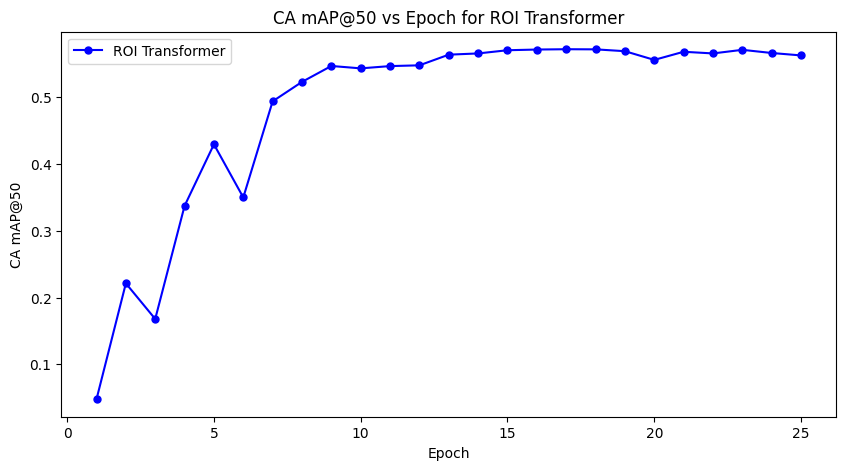

In [17]:
ca_mAP_df = saved_df.reset_index()[["Epoch", "CA mAP@50"]].set_index("Epoch")
# display(ca_mAP_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(ca_mAP_df.index, ca_mAP_df["CA mAP@50"], label=f"{model_config['head']}", marker='o', markersize=5, color='blue')
plt.title(f"CA mAP@50 vs Epoch for {model_config['head']}")
plt.xlabel("Epoch")
plt.ylabel("CA mAP@50")
plt.legend()
plt.savefig(f"./maps/{model_config['head']}_{model_config['backbone']}_ca_mAP.png")
plt.show()

In [18]:
# # Filter to include only epochs up to 50
# ca_mAP_df = ca_mAP_df[ca_mAP_df.index <= 50]
# Sort by CA mAP@50 values
sorted_df = ca_mAP_df.sort_values(by="CA mAP@50", ascending=False)
display(sorted_df.head(10))

,CA mAP@50
Epoch,
17,0.571862
18,0.571668
16,0.571384
23,0.570950
15,0.570345
19,0.568911
21,0.568046
24,0.566219
22,0.565556


In [20]:
best_epoch = sorted_df.index[0]
print(f"Best epoch: {best_epoch}")
# all maps
all_maps_df = saved_df.reset_index()[["Epoch", "CFCBK", "FCBK", "Zigzag", "Weighted mAP@50", "mAP@50:95", "mAP@50", "mAP@75",
                                      "CA mAP@50:95", "CA mAP@50", "CA mAP@75",
                                      "Precision", "Recall", "F1"
                                      ]].set_index("Epoch")
best_epoch_maps = all_maps_df.loc[best_epoch]
display(best_epoch_maps)

Best epoch: 17


CFCBK              0.325377
FCBK               0.506376
Zigzag             0.531856
Weighted mAP@50    0.347659
mAP@50:95          0.162329
mAP@50             0.454536
mAP@75             0.071561
CA mAP@50:95       0.220814
CA mAP@50          0.571862
CA mAP@75          0.111299
Precision          0.456486
Recall             0.714491
F1                 0.556821
Name: 17, dtype: float64